## Dataiku Data Challenge : Savings behavior in census data

This notebook explores census data from 1994/1995 and builds a predictive model of saving $50k on various explanatory factors.  A summary of insights derived from this analysis is provided in the dataiku_challenge_writeup_batorsky.docx file.

### Exploratory Analysis
- Variable distribution 
- Check percent missing or zero
    - If >75%, check there's not significant differences in zero/non-zero
    - If not significant, drop variable
- Check extreme variables

### Feature/model development
- Feature selection/transformation
- Model selection
- Model tuning

### Final predictions
- Transform test data to match train
- Predicting on transformed test data
- Prediction results



In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd
import scipy.stats as ss
import gzip

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer

/Users/B/anaconda/envs/gdelt/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Data set-up

In [2]:
#Features to be dropped
drop_cols = []

In [3]:
#Read metadata, extract descriptive names
colnames = []
#Names of continuous columns
cols_cont = []

with gzip.open('./data/census_income_metadata.txt.gz','rb') as f:
    for l in f.readlines():
        #Look for lines with metadata in them
        #I didn't use the tab-delimited meta-data as it doesn't match the data itself precisely
        if '#' in l:
            #Get words in parentheses
            col = l[l.find('(')+1:l.find(')')]
            #Add underscores, for ease of specification
            col = col.replace(' ','_')
            #If it's continuous, add to continuous colnames
            if 'nominal' not in l:
                cols_cont.append(col)
            #Append to name vector
            colnames.append(col)

In [4]:
#Colnames != width of data
#Data has target variable, add it
colnames.append('target')
#Also, col 24 is the weight variable, so need to insert that to align correctly
colnames.insert(24,'weight')

In [5]:
#Read in data function
#Allows specification of missing values (in this case: Not in universe and ?)
#Will strip whitespace from str columns
na_values = [' ?', ' Not in universe']
def readcensus(file, colnames, na_values):
    data = pd.read_csv(file, header = 0, compression = 'gzip',
                       names = colnames, na_values = na_values, index_col=None)
    for c in data.columns:
        if data[c].dtype.name=='object':
            data[c] = data[c].str.strip()
    return(data)
#Missing values are: ' Not in universe' 
data = readcensus('./data/census_income_learn.csv.gz', colnames, na_values)
data.head()

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,target
0,58,Self-employed-not incorporated,4,34,Some college but no degree,0,NaN,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,NaN,2,52,94,- 50000.
1,18,NaN,0,0,10th grade,0,High school,Never married,Not in universe or children,NaN,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,NaN,2,0,95,- 50000.
2,9,NaN,0,0,Children,0,NaN,Never married,Not in universe or children,NaN,...,United-States,United-States,United-States,Native- Born in the United States,0,NaN,0,0,94,- 50000.
3,10,NaN,0,0,Children,0,NaN,Never married,Not in universe or children,NaN,...,United-States,United-States,United-States,Native- Born in the United States,0,NaN,0,0,94,- 50000.
4,48,Private,40,10,Some college but no degree,1200,NaN,Married-civilian spouse present,Entertainment,Professional specialty,...,Philippines,United-States,United-States,Native- Born in the United States,2,NaN,2,52,95,- 50000.


In [6]:
#Add weight column to drop cols
drop_cols.append('weight')
data.drop('weight', axis=1, inplace=True)

In [7]:
#Binarize target variable
lb = LabelBinarizer()
data['target'] = lb.fit_transform(data.target.values)

In [8]:
#Data is ~200k observations, for ease of processing, conduct descriptives on sample
data_s  = data.sample(frac=.10)

## Descriptives

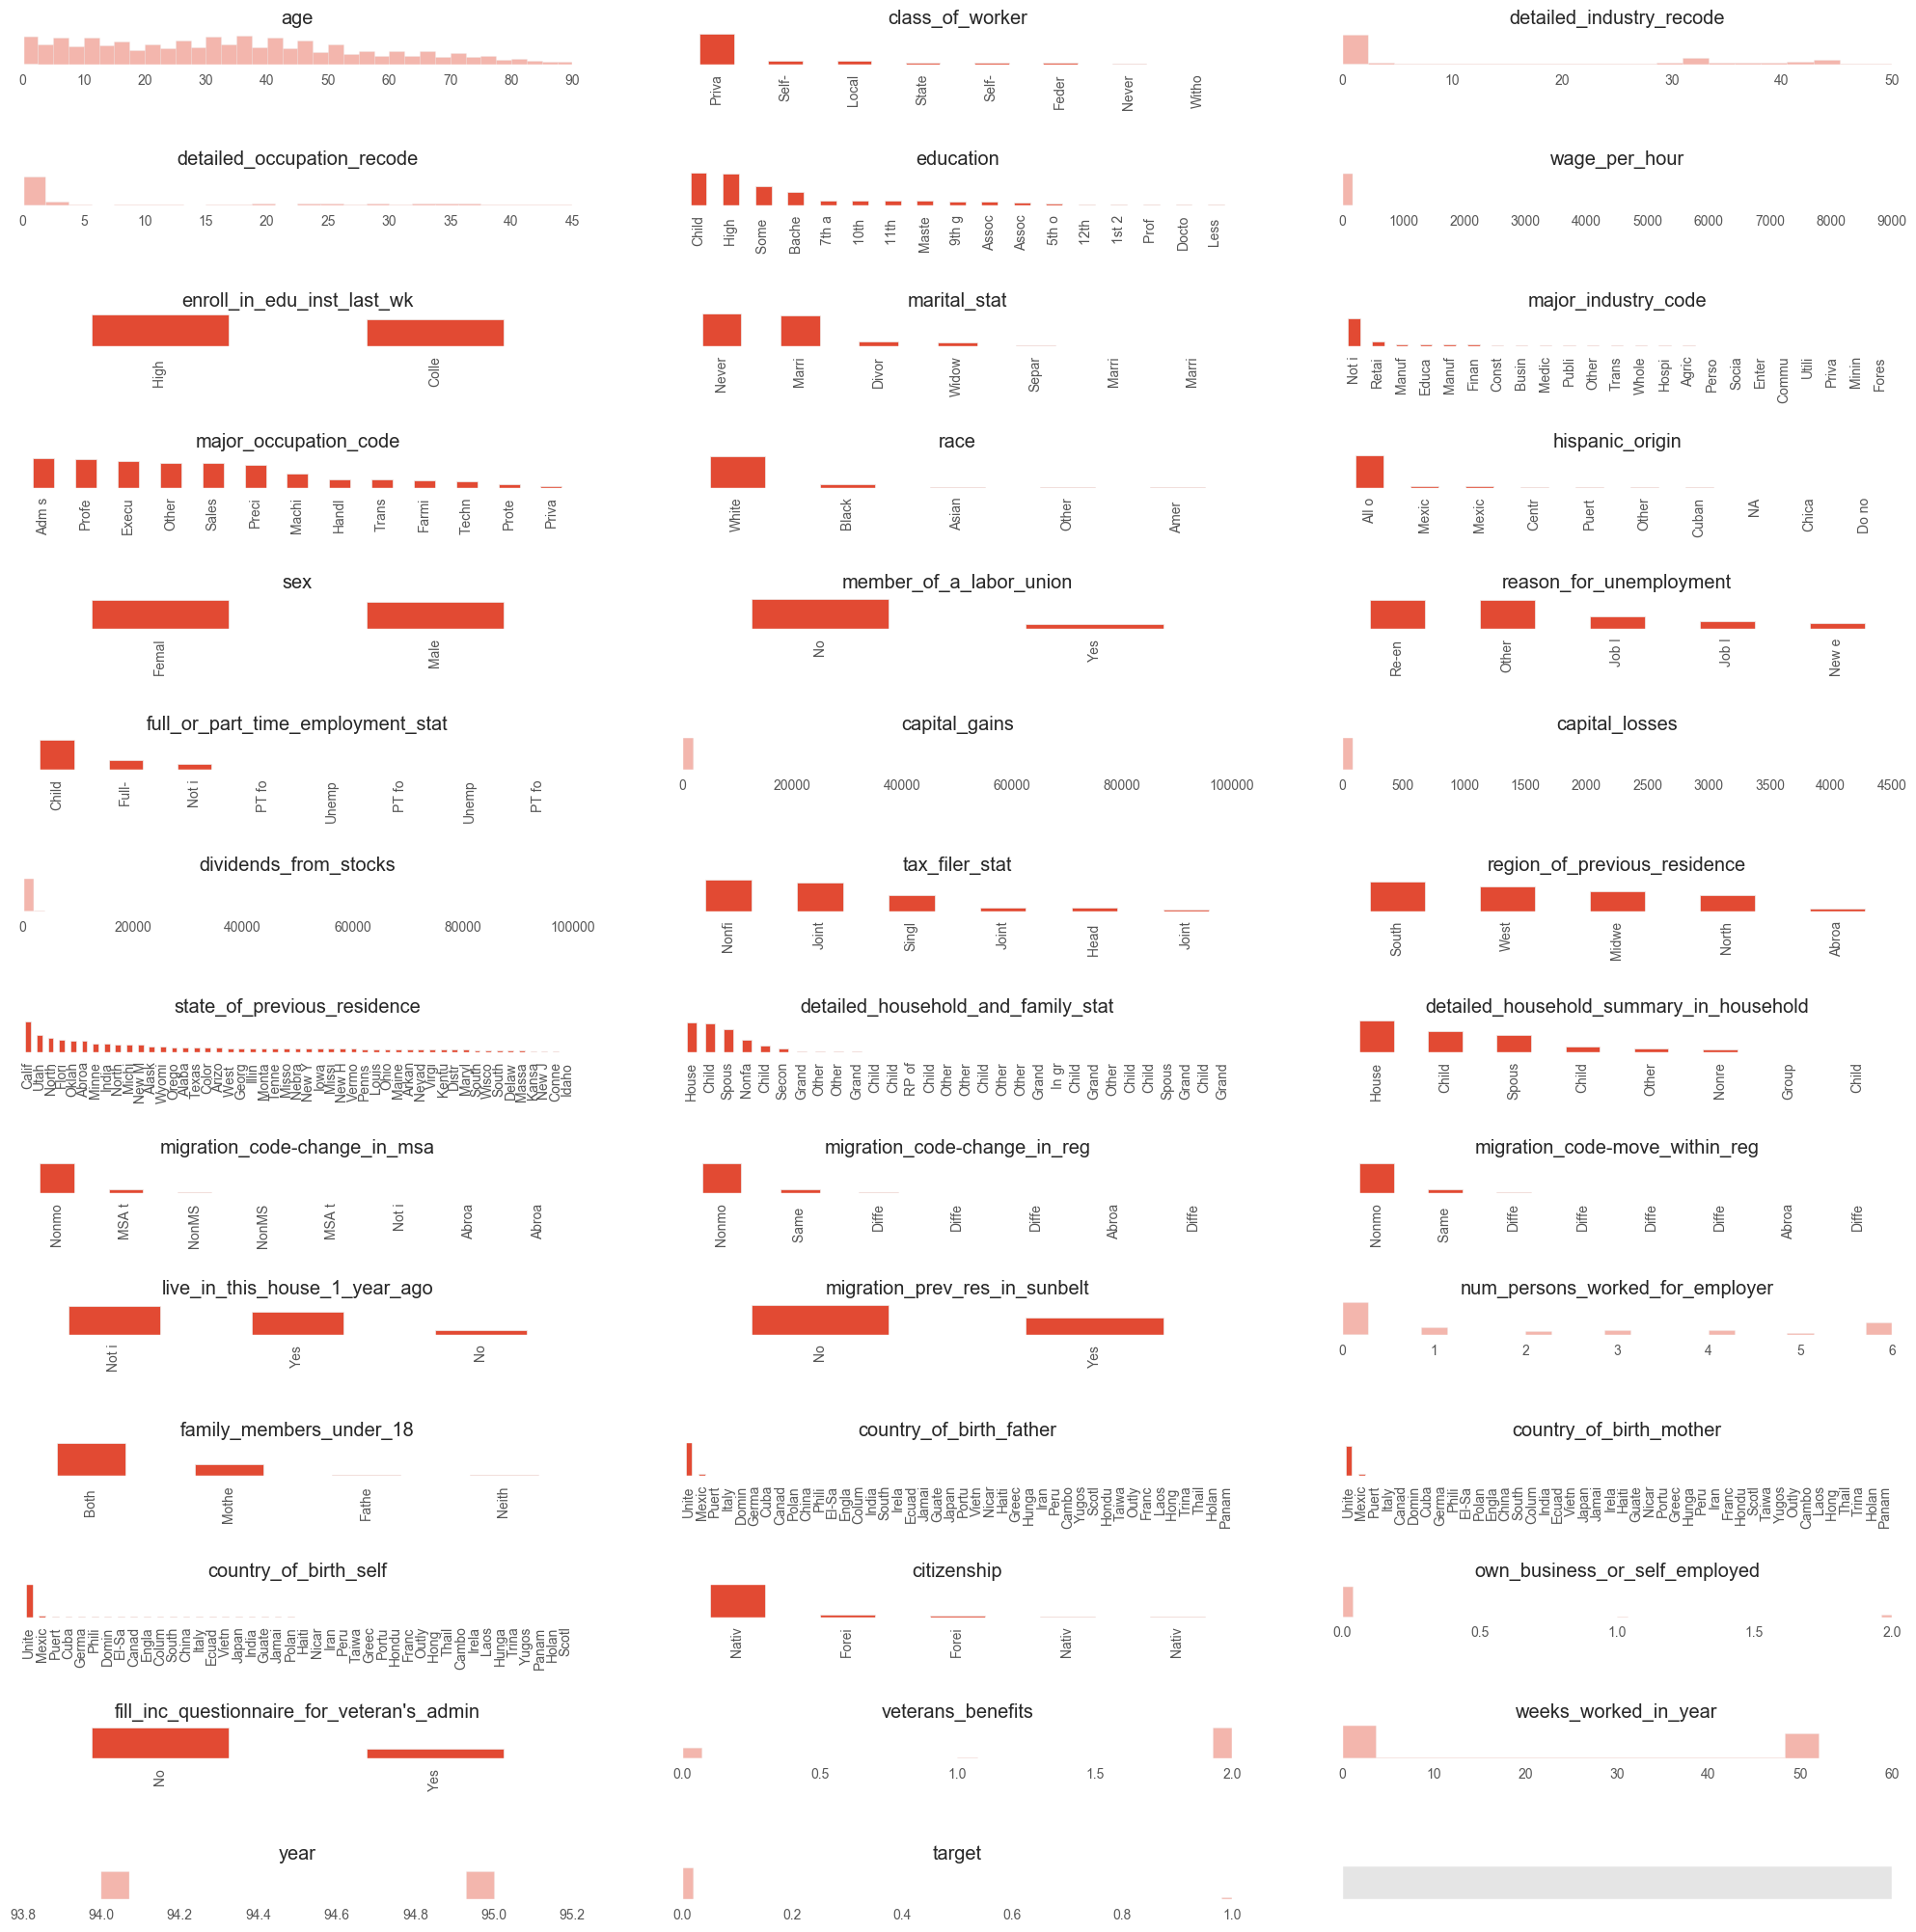

In [9]:
#Descriptive plots
plotcols = 3
plotrows = (len(data_s.columns)/plotcols)+1
fig,axs = plt.subplots(plotrows,plotcols, figsize=(25,25))
for ax in axs:
    [x.set_xticks([]) for x in ax]
    [x.set_yticks([]) for x in ax]
plotindex = 1
for c in data_s.columns:
    ax = fig.add_subplot(plotrows,plotcols,plotindex, title = c)
    #If continuous, do distplot
    if data_s[c].dtype.name == 'int64':
        sns.distplot(data_s[c], kde=False, ax = ax) 
    else:
        #If categorical, do histogram
        (data_s[c].value_counts()/len(data_s)).plot(kind='bar', ax = ax)
        #Make labels legible
        ax.set_xticklabels([x.get_text()[0:5] for x in ax.get_xticklabels()])
    ax.set_yticklabels('')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_axis_bgcolor('white')
    plotindex+=1
plt.subplots_adjust(hspace = 3.2)
plt.show()

In [10]:
#Large amounts of missing and zeros
#Check percentage for each column (either missing or zero)
def checkmissing(col):
    if col.dtype.name == 'int64':
        #Zeros
        result = ((col==0.0).value_counts()/len(col))
    else:
        #missing
        result = ((col.isnull()).value_counts()/len(col))
    return(result)

In [11]:
#Get stats for all missing/zero for each feature
data_missing = data.apply(lambda x: checkmissing(x))
#Only keep those with any missing/zero
data_missing = data_missing.dropna(axis=1)

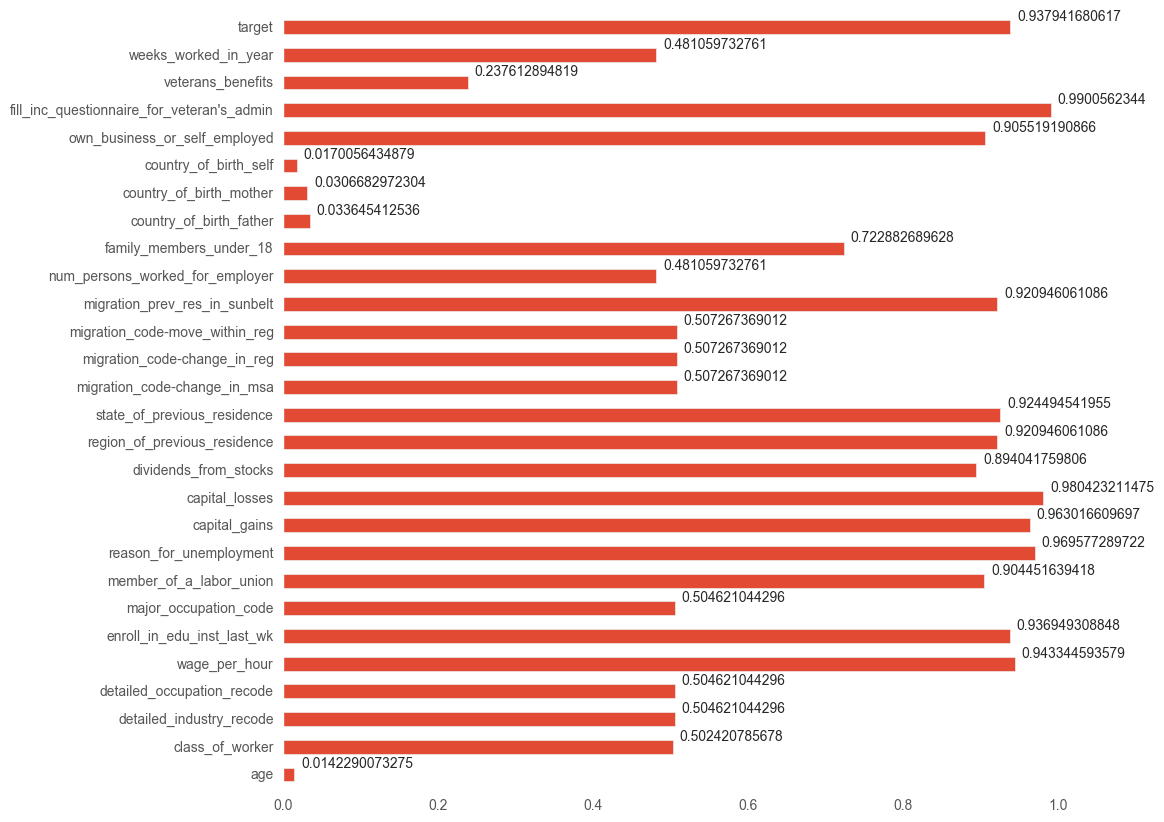

In [12]:
#Plot % missing/zero
def labelhbar(data): 
    p = data.plot(kind='barh', figsize=(10,10))
    p.set_axis_bgcolor('white')
    for i in p.patches:
        p.annotate(str(i.get_width()), (i.get_x() + i.get_width(), i.get_y()), xytext=(5, 10), textcoords='offset points')
    return(p)

p = labelhbar(data_missing.loc[True])
plt.show()

In [13]:
#My logic is that any columns (besides target) that have more than 80% missing or zero values, they should be dropped
#Test of this threshold is whether columns to be dropped have significant differences in target distribution
#Levene test, non-parameteric test of equal variance of target between null/non-nll
def testdiff(df,col):
    null = df[(col.isnull())|(col==0.0)].target
    nonnull = df[(col.notnull())|(col!=0.0)].target
    return(ss.levene(null,nonnull))

In [14]:
#Missing threshold
miss_th = .8
miss_gth = []
for c in data_missing.columns:
    if data_missing[c][True]>=miss_th:
        miss_gth.append(c)
#Remove target from this
miss_gth.remove('target')

In [15]:
#Run test
#Returns Levene statistic and p-value
data_levene = data[miss_gth].apply(lambda x: testdiff(data,x))
print data_levene

wage_per_hour                                       (0.988864468, 0.320020687651)
enroll_in_edu_inst_last_wk                     (25.9816367785, 3.44842313826e-07)
member_of_a_labor_union                        (57.6238065806, 3.18079090684e-14)
reason_for_unemployment                           (1.91122495241, 0.166828038043)
capital_gains                                  (188.216377438, 7.97238023334e-43)
capital_losses                                 (39.4759071363, 3.32476032024e-10)
dividends_from_stocks                         (971.916238004, 4.26815106231e-213)
region_of_previous_residence                      (6.24926910662, 0.012424870816)
state_of_previous_residence                      (6.25036235477, 0.0124172039899)
migration_prev_res_in_sunbelt                     (6.24926910662, 0.012424870816)
own_business_or_self_employed                  (29.7328823596, 4.96172925778e-08)
fill_inc_questionnaire_for_veteran's_admin       (0.510667561662, 0.474850436754)
dtype: object


In [16]:
#Add to Drop columns if zero/missing vs non-zero/nonmissing non-significantly different
for i in data_levene.index:
    if data_levene[i][1]>.05:
        drop_cols.append(i)

In [17]:
#Extreme values of continuous variables
#Check if any columns have values more than 2 standard deviations from mean
ex_dict = {}
for c in cols_cont:
    col_ex = (np.abs(data[c] - data[c].mean()) / data[c].std() > 2)
    if len(col_ex.value_counts())==2:
        print "{}, % more than 2 sd from mean : {}".format(c, 1.*col_ex.value_counts().loc[True]/len(data) )

age, % more than 2 sd from mean : 0.0273002475917
wage_per_hour, % more than 2 sd from mean : 0.0395294754463
capital_gains, % more than 2 sd from mean : 0.00925211254899
capital_losses, % more than 2 sd from mean : 0.0193261895931
dividends_from_stocks, % more than 2 sd from mean : 0.0106153707361


In [18]:
#With the 1-2% of individuals with extreme values, I feel confident dropping them
#They likely do not represent ordinary individuals (i.e. people with large capital investments and stock portfolios)
data = data[data[['capital_losses', 'dividends_from_stocks', 'capital_gains']].apply(lambda x: np.abs(x - x.mean()) / x.std() <= 2).all(axis=1)]

## Feature/Model Development

### Models
#### Logistic Regression - A good standby, offers interpretability of coefficients
#### Random Forest - Ensemble method for comparison with linear

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import grid_search as gs
from sklearn import cross_validation as cv
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [20]:
#Standard scaler
ssc = StandardScaler()
#Label encoder (multiple columns)
le = {}
#Create features dictionary, different by model
features = {}
features['LogisticRegression'] = []
features['RandomForest'] = []
#Copy data to train
train = data.copy(deep=True)

In [21]:
#For birthplace: Parents/self seem predominantly US
print train.groupby(train['country_of_birth_father']=='United-States')['country_of_birth_father'].count()
print train.groupby(train['country_of_birth_mother']=='United-States')['country_of_birth_mother'].count()
print train.groupby(train['country_of_birth_self']=='United-States')['country_of_birth_self'].count()
#I'm use binarized form of this
train['us_father'] = (train['country_of_birth_father']=='United-States').astype('int')
train['us_mother'] = (train['country_of_birth_mother']=='United-States').astype('int')
train['us_self'] = (train['country_of_birth_self']=='United-States').astype('int')
#Add to features
features['LogisticRegression'].extend(['us_father','us_mother','us_self'])
features['RandomForest'].extend(['us_father','us_mother','us_self'])

country_of_birth_father
False     32649
True     153044
Name: country_of_birth_father, dtype: int64
country_of_birth_mother
False     31949
True     154303
Name: country_of_birth_mother, dtype: int64
country_of_birth_self
False     18603
True     170215
Name: country_of_birth_self, dtype: int64


In [22]:
#Drop the drop columns
for c in drop_cols: 
    if c in train.columns:
        train.drop(c, axis=1, inplace=True)

In [23]:
#Transform features and add to features
#Convert categorical to indicator vars
dummies = {}
#Standard scaler for continuous variables for linear models, otherwise identity
for c in train.columns:
    if c != 'target':
        print "Transforming/encoding %s" % c
        #print train.head(5)
        if c in cols_cont:
            print "standard scaling"
            train[c+'_ss'] = ssc.fit_transform(train[c].reshape(-1,1))
            features['LogisticRegression'].append(c+'_ss')
            features['RandomForest'].append(c)
        elif c not in ['country_of_birth_father','country_of_birth_mother','country_of_birth_self']:
            #For the detailed recodes, I am labelencoding them
            #Likely not the best way to do this, but will create too many variables with indicators
            if len(train[c].unique())>10:
                print "label encoding"
                le[c] = LabelEncoder()
                train[c+'_encode'] = le[c].fit_transform(train[c])
                features['LogisticRegression'].append(c+'_encode')
                features['RandomForest'].append(c+'_encode')
            else:
                print "creating indicators"
                dummy_df = pd.get_dummies(train[c], prefix=c)
                dummies[c] = dummy_df.columns
                train = pd.concat([train, dummy_df], axis=1)
                features['LogisticRegression'].extend(dummies[c])
                features['RandomForest'].extend(dummies[c])

Transforming/encoding age
standard scaling
Transforming/encoding class_of_worker
creating indicators
Transforming/encoding detailed_industry_recode
label encoding
Transforming/encoding detailed_occupation_recode
label encoding
Transforming/encoding education
label encoding


/Users/B/anaconda/envs/gdelt/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/B/anaconda/envs/gdelt/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Transforming/encoding enroll_in_edu_inst_last_wk
creating indicators
Transforming/encoding marital_stat
creating indicators
Transforming/encoding major_industry_code
label encoding
Transforming/encoding major_occupation_code
label encoding
Transforming/encoding race
creating indicators


/Users/B/anaconda/envs/gdelt/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


Transforming/encoding hispanic_origin
creating indicators
Transforming/encoding sex
creating indicators
Transforming/encoding member_of_a_labor_union
creating indicators
Transforming/encoding full_or_part_time_employment_stat
creating indicators
Transforming/encoding capital_gains
standard scaling
Transforming/encoding capital_losses
standard scaling
Transforming/encoding dividends_from_stocks
standard scaling
Transforming/encoding tax_filer_stat
creating indicators


/Users/B/anaconda/envs/gdelt/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/B/anaconda/envs/gdelt/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/B/anaconda/envs/gdelt/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/B/anaconda/envs/gdelt/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/B/anaconda/envs/gdelt/lib/python2.7/site-packages/sklearn/utils/validation.py

Transforming/encoding region_of_previous_residence
creating indicators
Transforming/encoding state_of_previous_residence
label encoding
Transforming/encoding detailed_household_and_family_stat
label encoding
Transforming/encoding detailed_household_summary_in_household
creating indicators
Transforming/encoding migration_code-change_in_msa
creating indicators
Transforming/encoding migration_code-change_in_reg
creating indicators
Transforming/encoding migration_code-move_within_reg
creating indicators
Transforming/encoding live_in_this_house_1_year_ago
creating indicators
Transforming/encoding migration_prev_res_in_sunbelt
creating indicators
Transforming/encoding num_persons_worked_for_employer
standard scaling
Transforming/encoding family_members_under_18
creating indicators


/Users/B/anaconda/envs/gdelt/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/B/anaconda/envs/gdelt/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Transforming/encoding country_of_birth_father
Transforming/encoding country_of_birth_mother
Transforming/encoding country_of_birth_self
Transforming/encoding citizenship
creating indicators
Transforming/encoding own_business_or_self_employed
creating indicators
Transforming/encoding veterans_benefits
creating indicators
Transforming/encoding weeks_worked_in_year
standard scaling
Transforming/encoding year
creating indicators


/Users/B/anaconda/envs/gdelt/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/B/anaconda/envs/gdelt/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Transforming/encoding us_father
creating indicators
Transforming/encoding us_mother
creating indicators
Transforming/encoding us_self
creating indicators


In [24]:
#Model parameters
#Which models
models = ['RandomForest','LogisticRegression'] 
params = dict()

#general hyperparameters
njobs = -1 #number of jobs to run in parallel
pmetric = 'roc_auc' #Useful for unbalanced classes
verb = 1

#tuning parameters for randomizedsearchcv
import scipy.stats as ss
params['iter'] = 3 #number of iterations
params['folds'] = 3 #folds for cv (default)

#LogisticRegression model parameters
params['LogisticRegression'] = dict()
params['LogisticRegression']['penalty'] = ['l1','l2']
params['LogisticRegression']['C'] = ss.beta(a=2,b=25) #beta distribution for selecting reg strength

#RandomForest model parameters
params['RandomForest'] = dict()
params['RandomForest']['n_estimators'] = [2**8] #number of trees in the forest
params['RandomForest']['max_features'] = ss.beta(a=2,b=15) #number of features at split
params['RandomForest']['max_leaf_nodes'] = ss.nbinom(n=2,p=0.001,loc=100) #max number of leaves to create

In [25]:
def gridsearch(data,target,features,model,mparams, sample=None):
    #Running on sample, since data too large for easy compute
    if sample:
        data = data.sample(frac=sample)
    #Get train/test
    x,y = data[features], data[target]
    if model == 'LogisticRegression':
        lr = LogisticRegression(class_weight='balanced')
        grid = gs.RandomizedSearchCV(lr, 
                    dict(
                        penalty=mparams['penalty'],
                        C=mparams['C']
                        ), 
                    scoring=pmetric, n_jobs=njobs, 
                    cv = cv.KFold(len(data),params['folds']), 
                    verbose=verb, refit=False, n_iter=params['iter'])
    else:
        rf = RandomForestClassifier(criterion='gini', bootstrap=True, n_jobs=1, 
                verbose=0, oob_score=False, class_weight='balanced_subsample')        
        grid = gs.RandomizedSearchCV(rf, 
                    dict(
                        n_estimators=mparams['n_estimators'],
                        max_features=mparams['max_features'],
                        max_leaf_nodes=mparams['max_leaf_nodes']
                        ), 
                    scoring=pmetric, n_jobs=njobs, 
                    cv=cv.KFold(len(data), params['folds']), 
                    verbose=verb, refit=False, n_iter=params['iter'])
    grid.fit(X=x,y=y)    
    bp = grid.best_params_
    bs = grid.best_score_
    return(bs, bp)

In [26]:
#Run both models, store score and params
scores = {}
pars = {}
models = ['LogisticRegression', 'RandomForest']
for mod in models:
    bs, bp = gridsearch(train, 'target', features[mod], mod, params[mod], sample=.1)
    scores[mod] = bs
    pars[mod] = bp
    print "Best ROC AUC for {}: {}".format(mod, bs)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    5.9s finished


Best ROC AUC for LogisticRegression: 0.917387985334
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best ROC AUC for RandomForest: 0.909689953683


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   19.9s finished


In [28]:
#Read in test set, process
#Ideally, this would be part of a pipeline
test = readcensus('./data/census_income_test.csv.gz', colnames, na_values)
test['target'] = lb.fit_transform(test.target.values)
test['us_father'] = (test['country_of_birth_father']=='United-States').astype('int')
test['us_mother'] = (test['country_of_birth_mother']=='United-States').astype('int')
test['us_self'] = (test['country_of_birth_self']=='United-States').astype('int')
#Drop the drop columns
for c in drop_cols: 
    if c in test.columns:
        test.drop(c, axis=1, inplace=True)
#Transform features
#Standard scaler for continuous variables for linear models, otherwise identity
for c in test.columns:
    if c != 'target':
        print "Transforming/encoding %s" % c
        if c in cols_cont:
            print "standard scaling"
            test[c+'_ss'] = ssc.fit_transform(test[c].reshape(-1,1))
        elif c not in ['country_of_birth_father','country_of_birth_mother','country_of_birth_self']:
            if len(train[c].unique())>10:
                print "label encoding"
                test[c+'_encode'] = le[c].transform(test[c])
            else:
                print "creating indicators"
                dummy_df = pd.get_dummies(test[c])
                test = pd.concat([test, dummy_df], axis=1)
#Ensure that all features from train are in test
#If not, test likely has some different categories, need to add a vector of 0's for it
for f in features['LogisticRegression']:
    if f not in test.columns:
        test[f] = 0.0

Transforming/encoding age
standard scaling
Transforming/encoding class_of_worker
creating indicators
Transforming/encoding detailed_industry_recode
label encoding
Transforming/encoding detailed_occupation_recode
label encoding
Transforming/encoding education
label encoding


/Users/B/anaconda/envs/gdelt/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/B/anaconda/envs/gdelt/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Transforming/encoding enroll_in_edu_inst_last_wk
creating indicators
Transforming/encoding marital_stat
creating indicators
Transforming/encoding major_industry_code
label encoding
Transforming/encoding major_occupation_code
label encoding


/Users/B/anaconda/envs/gdelt/lib/python2.7/site-packages/numpy/lib/arraysetops.py:259: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  return aux[:-1][aux[1:] == aux[:-1]]


Transforming/encoding race
creating indicators
Transforming/encoding hispanic_origin
creating indicators
Transforming/encoding sex
creating indicators
Transforming/encoding member_of_a_labor_union
creating indicators
Transforming/encoding full_or_part_time_employment_stat
creating indicators
Transforming/encoding capital_gains
standard scaling
Transforming/encoding capital_losses
standard scaling
Transforming/encoding dividends_from_stocks
standard scaling
Transforming/encoding tax_filer_stat
creating indicators


/Users/B/anaconda/envs/gdelt/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/B/anaconda/envs/gdelt/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/B/anaconda/envs/gdelt/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/B/anaconda/envs/gdelt/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/B/anaconda/envs/gdelt/lib/python2.7/site-packages/sklearn/utils/validation.py

Transforming/encoding region_of_previous_residence
creating indicators
Transforming/encoding state_of_previous_residence
label encoding
Transforming/encoding detailed_household_and_family_stat
label encoding
Transforming/encoding detailed_household_summary_in_household
creating indicators
Transforming/encoding migration_code-change_in_msa
creating indicators
Transforming/encoding migration_code-change_in_reg
creating indicators
Transforming/encoding migration_code-move_within_reg
creating indicators
Transforming/encoding live_in_this_house_1_year_ago
creating indicators
Transforming/encoding migration_prev_res_in_sunbelt
creating indicators
Transforming/encoding num_persons_worked_for_employer
standard scaling


/Users/B/anaconda/envs/gdelt/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/B/anaconda/envs/gdelt/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Transforming/encoding family_members_under_18
creating indicators
Transforming/encoding country_of_birth_father
Transforming/encoding country_of_birth_mother
Transforming/encoding country_of_birth_self
Transforming/encoding citizenship
creating indicators
Transforming/encoding own_business_or_self_employed
creating indicators
Transforming/encoding veterans_benefits
creating indicators
Transforming/encoding weeks_worked_in_year
standard scaling
Transforming/encoding year
creating indicators


/Users/B/anaconda/envs/gdelt/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/B/anaconda/envs/gdelt/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Transforming/encoding us_father
creating indicators
Transforming/encoding us_mother
creating indicators
Transforming/encoding us_self
creating indicators


In [31]:
def aucplt(train, test, best_params, features,save=False):
    fit_ms = {}
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    
    for i in ['LogisticRegression', 'RandomForest']:
        if i == 'RandomForest':
            m = RandomForestClassifier(n_estimators=best_params[i]['n_estimators'], 
                max_features=best_params[i]['max_features'], 
                max_leaf_nodes=best_params[i]['max_leaf_nodes'],
                criterion='gini', bootstrap=True, n_jobs=njobs,
                oob_score=False, class_weight='balanced_subsample')
            fit_m = m.fit(train[features[i]],train['target'])
        elif i == 'LogisticRegression':
            m = LogisticRegression(penalty=best_params[i]['penalty'],class_weight='balanced', C = best_params[i]['C'])
            fit_m = m.fit(train[features[i]],train['target'])
        fit_ms[i] = fit_m
        m_pred = m.predict_proba(test[features[i]])[:, 1]
        fpr_m, tpr_m, _ = roc_curve(test['target'], m_pred)
        plt.plot(fpr_m, tpr_m, label=i)
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(loc='best')
                
    if save:
        plt.savefig('roc.png', facecolor='white')
    plt.show()
    
    return(fit_ms)

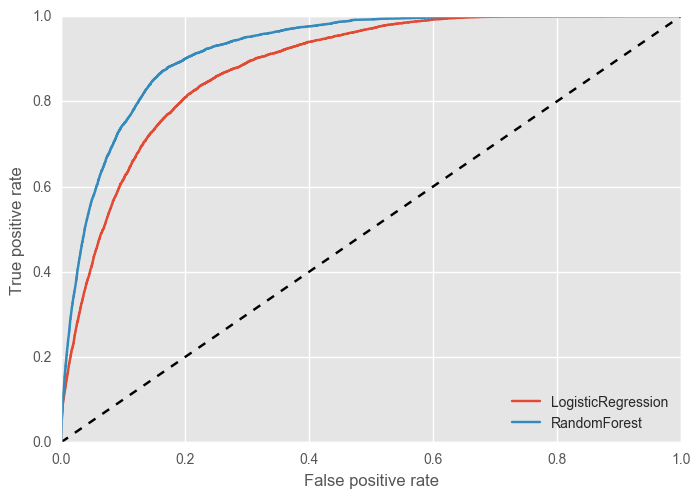

In [32]:
fit_ms = aucplt(train, test, pars, features)

In [33]:
leveneDict = {}
for f in features['LogisticRegression']:
    train_g = train.groupby(f)
    leveneDict[f] = ss.levene(*[train_g.get_group(k)['target'].values for k in train_g.groups])

In [34]:
#Features, sorted by significant difference in numbers of people saving $50k
levene_sort = sorted(leveneDict.items(), key=lambda x: x[1], reverse=True)
for i in levene_sort:
    print '{} p-value: {}'.format(i[0], i[1][1])

tax_filer_stat_Joint both under 65 p-value: 0.0
tax_filer_stat_Nonfiler p-value: 0.0
detailed_household_summary_in_household_Householder p-value: 0.0
marital_stat_Married-civilian spouse present p-value: 0.0
marital_stat_Never married p-value: 0.0
sex_Male p-value: 0.0
sex_Female p-value: 0.0
full_or_part_time_employment_stat_Full-time schedules p-value: 0.0
detailed_household_summary_in_household_Child under 18 never married p-value: 0.0
veterans_benefits_0 p-value: 0.0
class_of_worker_Self-employed-incorporated p-value: 0.0
veterans_benefits_2 p-value: 0.0
class_of_worker_Private p-value: 0.0
family_members_under_18_Both parents present p-value: 0.0
major_occupation_code_encode p-value: 0.0
num_persons_worked_for_employer_ss p-value: 0.0
education_encode p-value: 0.0
own_business_or_self_employed_1 p-value: 1.26728207572e-223
class_of_worker_Federal government p-value: 2.92185654933e-212
full_or_part_time_employment_stat_Children or Armed Forces p-value: 2.77331053561e-209
full_or_pa